In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

<img src='image/kalman_fig4_2.png' width =640px>

## State Vector

Constant Velocity Model for Ego Motion

$$x_k= \left[ \matrix{ x \\ y \\ \dot x \\ \dot y} \right] = \matrix{ \text{Position X} \\ \text{Position Y} \\ \text{Velocity in X} \\ \text{Velocity in Y}}$$

### Initial State $x_0$

$$x_{0} = \begin{bmatrix}0 \\ 0 \\ 0 \\ 0\end{bmatrix}$$

In [3]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)
#plt.scatter(float(x[0]),float(x[1]), s=100)
#plt.title('Initial Location')

(matrix([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]), (4, 1))


Formal Definition (Motion of Law):

$$x_{k+1} = \textbf{A} \cdot x_{k}$$

which is

$$x_{k+1} = \begin{bmatrix}1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ \dot x \\ \dot y \end{bmatrix}_{k}$$

Observation Model:

$$y = \textbf{H} \cdot x$$

which is

$$y = \begin{bmatrix}0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix} \cdot x$$ means: You observe the velocity directly in the correct unit

### Initial Uncertainty $P_0$

$$P_{0} = \begin{bmatrix}\sigma^2_x & 0 & 0 & 0 \\ 0 & \sigma^2_y & 0 & 0 \\ 0 & 0 & \sigma^2_{\dot x} & 0 \\ 0 & 0 & 0 & \sigma^2_{\dot y} \end{bmatrix}$$

with $\sigma$ as the standard deviation

In [4]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0])
print(P, P.shape)

(array([[ 1000.,     0.,     0.,     0.],
       [    0.,  1000.,     0.,     0.],
       [    0.,     0.,  1000.,     0.],
       [    0.,     0.,     0.,  1000.]]), (4, 4))


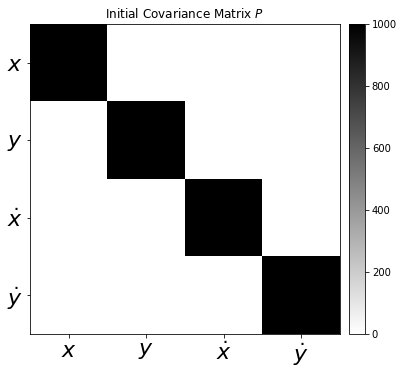

In [5]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

### Dynamic Matrix $A$

It is calculated from the dynamics of the Egomotion.

$$x_{k+1} = x_{k} + \dot x_{k} \cdot \Delta t$$
$$y_{k+1} = y_{k} + \dot y_{k} \cdot \Delta t$$
$$\dot x_{k+1} = \dot x_{k}$$
$$\dot y_{k+1} = \dot y_{k}$$

In [6]:
dt = 0.1 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, dt, 0.0],
              [0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

(matrix([[ 1. ,  0. ,  0.1,  0. ],
        [ 0. ,  1. ,  0. ,  0.1],
        [ 0. ,  0. ,  1. ,  0. ],
        [ 0. ,  0. ,  0. ,  1. ]]), (4, 4))


### Measurement Matrix $H$

We directly measure the Velocity $\dot x$ and $\dot y$

$$H = \begin{bmatrix}0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}$$

This matrix influences the Kalman Gain.

In [7]:
H = np.matrix([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

(matrix([[ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]]), (2, 4))


### Measurement Noise Covariance $R$

Tells the Kalman Filter how 'bad' the sensor readings are.

That is, $R$ is the sensor noise matrix. This matrix implies the measurement error covariance, based on the amount of sensor noise.

$$R = \begin{bmatrix}\sigma^2_{\dot x} & 0 \\ 0 & \sigma^2_{\dot y} \end{bmatrix}$$

In [8]:
ra = 10.0**2

R = np.matrix([[ra, 0.0],
              [0.0, ra]])
print(R, R.shape)

(matrix([[ 100.,    0.],
        [   0.,  100.]]), (2, 2))


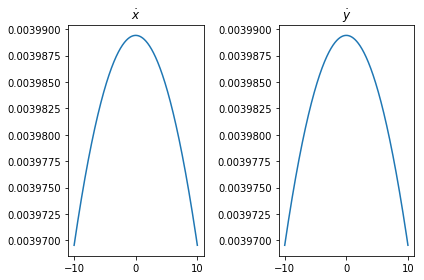

In [9]:
# Plot between -10 and 10 with .001 steps.
xpdf = np.arange(-10, 10, 0.001)
plt.subplot(121)
plt.plot(xpdf, norm.pdf(xpdf,0,R[0,0]))
plt.title('$\dot x$')

plt.subplot(122)
plt.plot(xpdf, norm.pdf(xpdf,0,R[1,1]))
plt.title('$\dot y$')
plt.tight_layout()

### Process Noise Covariance $Q$

Q is the action uncertainty matrix. This matrix implies the process noise covariance.

The position of the car can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). This process noise has to be modeled with the process noise covariance matrix Q.

$$Q = \begin{bmatrix}\sigma_{x}^2 & \sigma_{xy} & \sigma_{x \dot x} & \sigma_{x \dot y} \\ \sigma_{yx} & \sigma_{y}^2 & \sigma_{y \dot x} & \sigma_{y \dot y} \\ \sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\ \sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2 \end{bmatrix}$$

One can calculate Q as

$$Q = G\cdot G^T \cdot \sigma_v^2$$

with $G = \begin{bmatrix}0.5dt^2 & 0.5dt^2 & dt & dt\end{bmatrix}^T$ and $\sigma_v$ as the acceleration process noise, which can be assumed for a vehicle to be $8.8m/s^2$, according to: Schubert, R., Adam, C., Obst, M., Mattern, N., Leonhardt, V., & Wanielik, G. (2011). [Empirical evaluation of vehicular models for ego motion estimation](http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=5940526). 2011 IEEE Intelligent Vehicles Symposium (IV), 534–539. doi:10.1109/IVS.2011.5940526

In [10]:
sv = 8.8

G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])

Q = G*G.T*sv**2

In [11]:
m = 200 # Measurements
vx= 20 # in X
vy= 10 # in Y

mx = np.array(vx+np.random.randn(m))
my = np.array(vy+np.random.randn(m))

measurements = np.vstack((mx,my))

print(measurements.shape)

print('Standard Deviation of Acceleration Measurements=%.2f' % np.std(mx))
print('You assumed %.2f in R.' % R[0,0])

(2, 200)
Standard Deviation of Acceleration Measurements=0.97
You assumed 100.00 in R.


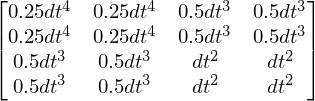

In [12]:
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing()
dts = Symbol('dt')
Qs = Matrix([[0.5*dts**2],[0.5*dts**2],[dts],[dts]])
Qs*Qs.T

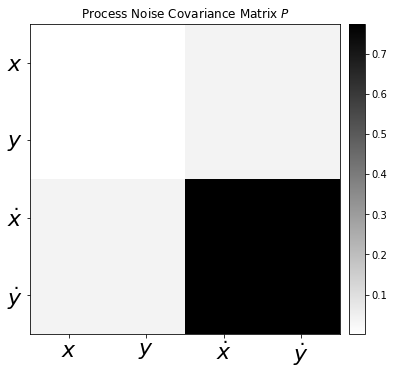

In [13]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

### Identity Matrix $I$

In [14]:
I = np.eye(4)
print(I, I.shape)

(array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]]), (4, 4))


### Measurements
For example, we are using some random generated measurement values

In [15]:
m = 200 # Measurements
vx= 20 # in X
vy= 10 # in Y

mx = np.array(vx+np.random.randn(m))
my = np.array(vy+np.random.randn(m))

measurements = np.vstack((mx,my))

print('measurements.shape = {}'.format(measurements.shape))

print('Standard Deviation of Acceleration Measurements=%.2f' % np.std(mx))
print('You assumed %.2f in R. <-- R[0,0]' % R[0,0])
print('R = Measurement Noise Covariance = tells how bad the sensor readings are.')

measurements.shape = (2, 200)
Standard Deviation of Acceleration Measurements=1.13
You assumed 100.00 in R. <-- R[0,0]
R = Measurement Noise Covariance = tells how bad the sensor readings are.


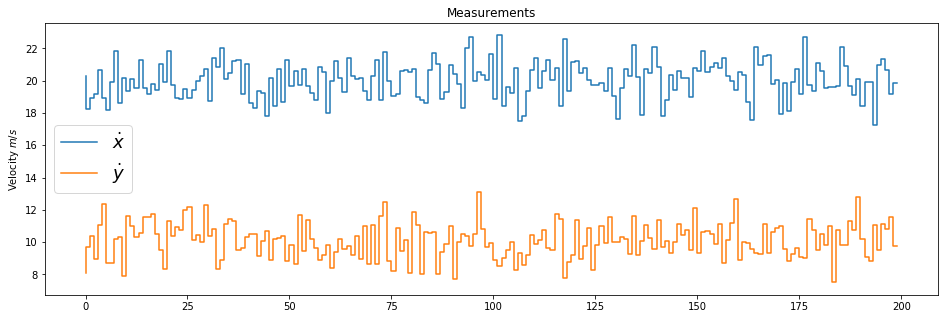

In [16]:
fig = plt.figure(figsize=(16,5))

plt.step(range(m),mx, label='$\dot x$')
plt.step(range(m),my, label='$\dot y$')
plt.ylabel(r'Velocity $m/s$')
plt.title('Measurements')
plt.legend(loc='best',prop={'size':18})

In [17]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []

In [18]:
def savestates(x, Z, P, R, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))    

In [19]:
def plot_K():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
    plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
    plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
    plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
    plt.legend(loc='best',prop={'size':22})

<img src='image/kalman_fig4_2.png' width =640px>

$\hat{x}^{-}_{k}=A\hat{x}_{k-1}+Bu_k$

* $\hat{x}^{-}_{k}$ (note the “super minus”) 
>* a priori state estimate at step k given knowledge of the process prior to step $k$
>
>* gained by knowledge of the system

* $\hat{x}_{k}$ 
>* a posteriori state estimate at step k given measurement $z_{k}$ 
>* a linear combination of an a priori estimate $\hat{x}^{-}_{k}$ and a weighted difference between an actual measurement $z_{k}$ and a measurement prediction $\hat{x}^{-}_{k}$
* $z_{k} - H\hat{x}^{-}_{k}$ 
>* measurement innovation, or the residual.
 

In [20]:
for n in range(len(measurements[0])):
 
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,n].reshape(2,1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
    # Save states (for Plotting)
    savestates(x, Z, P, R, K)

Job Done !

## Visualization

### Kalman Gains $K$
* Kalman gain : fraction between 0 and 1
* If the Kalman gain is large that means we have a very small assumed error in the measurement, then we want to take the value and the predicted value and add that to the predicted value.
* $K_k=P_k^\prime H^T\left(HP_k^\prime H^T+R\right)^{-1}$ 이고, ${\hat{x}}_k={\hat{x}}_k^\prime+K_k\left(z_k-H{\hat{x}}_k^\prime\right) $ 이므로, 극단적인 예로 $K_k=0$ 이면 ($R$이 커서..), $z_k$ 가 업데이트에 반영이 안됨



In [21]:
print(np.shape(measurements[0]))

(200,)


In [22]:
def plot_K():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
    plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
    plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
    plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
    plt.legend(loc='best',prop={'size':22})

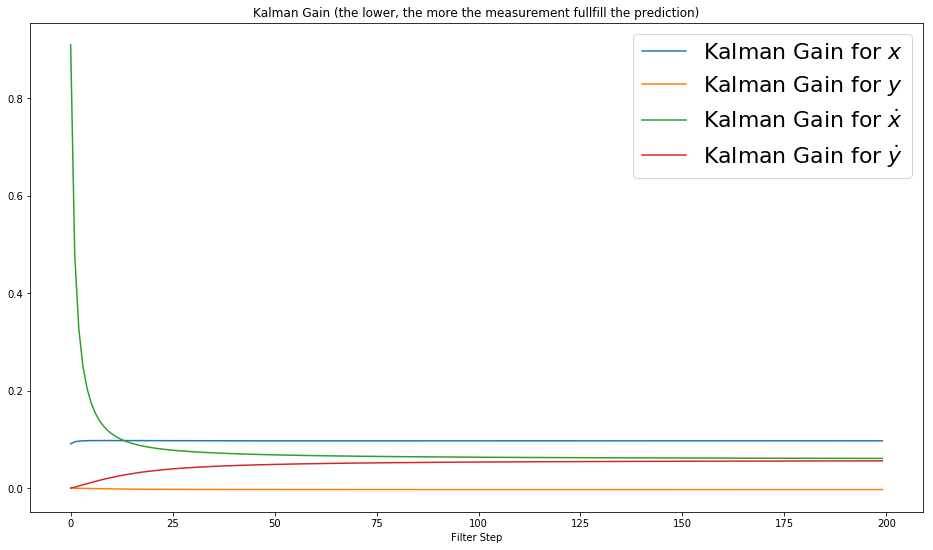

In [23]:
plot_K()

낮을수록?

### Uncertainty Matrix $P$

In [24]:
def plot_P():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(len(measurements[0])),Px, label='$x$')
    plt.plot(range(len(measurements[0])),Py, ':', label='$y$')
    plt.plot(range(len(measurements[0])),Pdx,  label='$\dot x$')
    plt.plot(range(len(measurements[0])),Pdy, ':',label='$\dot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})

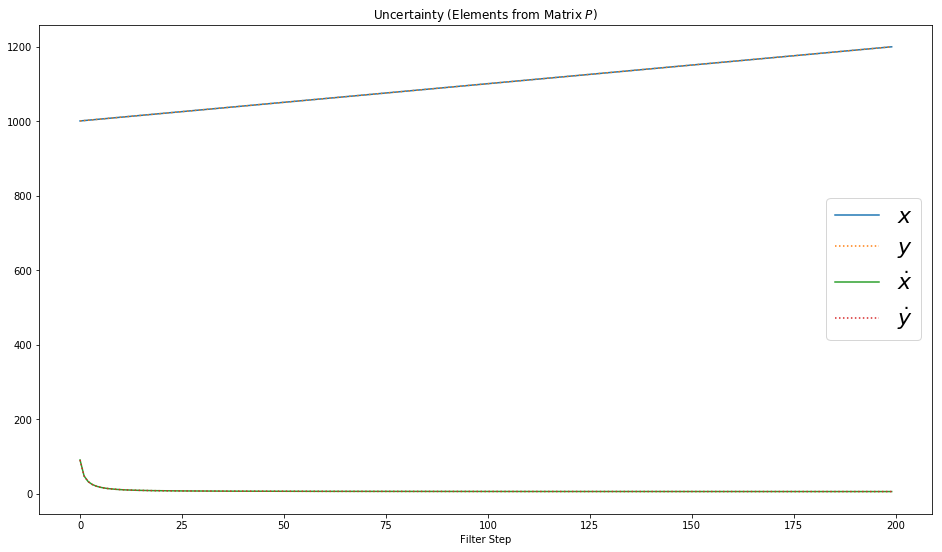

In [25]:
plot_P()

속도는 측정을 하니까.? position은 점점 더 불확실.

### State Estimate $x$

In [26]:
def plot_x():
    fig = plt.figure(figsize=(16,9))
    plt.step(range(len(measurements[0])),dxt, label='$\dot x$')
    plt.step(range(len(measurements[0])),dyt, label='$\dot y$')

    plt.axhline(vx, color='#999999', label='$\dot x_{real}$')
    plt.axhline(vy, color='#999999', label='$\dot y_{real}$')

    plt.xlabel('Filter Step')
    plt.title('Estimate (Elements from State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylim([0, 30])
    plt.ylabel('Velocity')

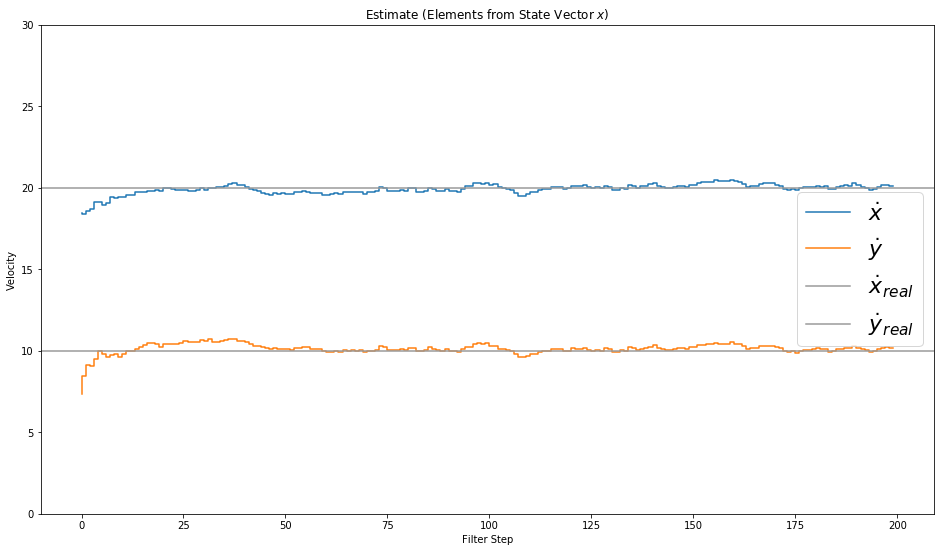

In [27]:
plot_x()

## Position x/y

In [28]:
def plot_xy():
    fig = plt.figure(figsize=(16,16))
    plt.scatter(xt,yt, s=20, label='State', c='k')
    plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
    plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')
    
    xfin = 0+ vx*m * dt 
    yfin = 0+ vy*m * dt
    print(xfin, yfin)
    plt.scatter(xfin, yfin, s=100, label='Calc', c='m')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Position')
    plt.legend(loc='best')
    plt.axis('equal')

(400.0, 200.0)


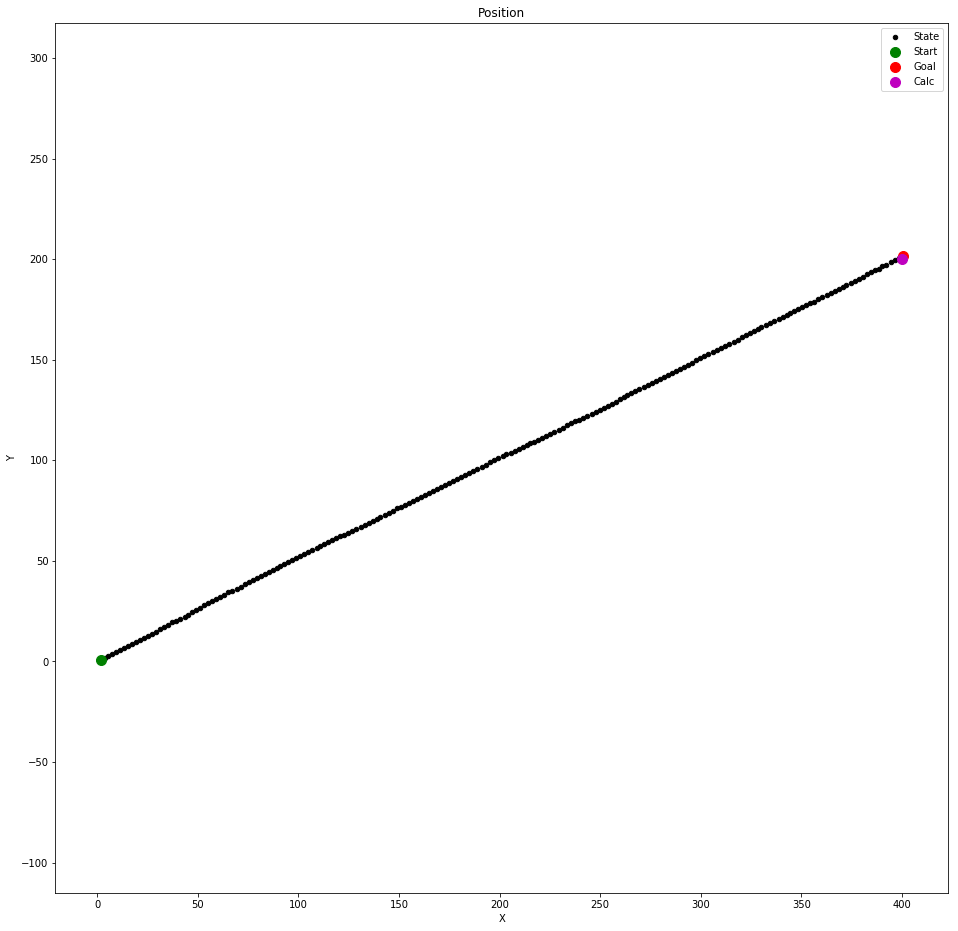

In [29]:
plot_xy()

It works pretty well. That was basically just dead reckoning, because no position measurement came in.

* https://github.com/balzer82/Kalman
* https://github.com/balzer82/Kalman/blob/master/Kalman-Filter-CV.ipynb
* https://tex.stackexchange.com/a/218550
* Bishop, Gary, and Greg Welch. "An introduction to the Kalman filter." Proc of SIGGRAPH, Course 8.27599-3175 (2001): 59.
* Kalman Filter Simulation, https://www.cs.utexas.edu/~teammco/misc/kalman_filter/